In [28]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import deque, defaultdict
from linearApprox import *
from collections import deque

In [29]:
def getReward2(action, goal_success_queues, total_timesteps, pSwap, epsilon=0.001, success=True):
    reward = 0.0
    consumed_edges, goal_edge = action
    if goal_edge is None or not consumed_edges:
        return 0

    success_prob = pSwap ** (len(consumed_edges) - 1)
    edr = sum(goal_success_queues[goal_edge]) / max(1, len(goal_success_queues[goal_edge])) + epsilon
    expected_reward = math.log(1 + (success_prob / edr))

    if success:
        reward += expected_reward
        goal_success_queues[goal_edge].append(1)
    else:
        # Reward attempt even if failed
        attempt_bonus = 0.5 * expected_reward  # or some fixed value like 0.2
        reward += attempt_bonus
        goal_success_queues[goal_edge].append(0)

    return reward


def run_n_step_sarsa_linear(
    initialEdges, goalEdges, totalSteps, nLookahead,
    epsilon, gamma, alpha, pGen, pSwap, maxAge,
    edr_window_size=100, convergence_epsilon=0.001, plot=False,
    softmax=False, temperature=1.0, temperature_decay=1.0
):
    def select_action(state, temperature, epsilon, softmax):
        features = featurize_state(state, goal_order=goalEdges)
        possible_actions = getPossibleActions(state[0], goalEdges)

        if softmax:
            q_vals = [Q.get_q_value(features, a) for a in possible_actions]
            probs = softmax_probs(q_vals, temperature)
            return random.choices(possible_actions, weights=probs)[0]
        else:
            return random.choice(possible_actions) if random.random() < epsilon else max(
                possible_actions, key=lambda a: Q.get_q_value(features, a)
            )
    feature_size = len(initialEdges) + len(goalEdges)
    Q = LinearQApproximator(feature_size=feature_size)
    q_value_diffs = []

    goal_success_queues = {goal: deque(maxlen=edr_window_size) for goal in goalEdges}
    raw_state = [(edge, -1) for edge in initialEdges]
    rolling_edrs = {goal: 0.0 for goal in goalEdges}
    current_state = get_augmented_state(raw_state, rolling_edrs, goal_order=goalEdges)

    print("\nStarting n-step SARSA (Linear Approximation)...")



    # Initialize first action
    features = featurize_state(current_state, goal_order=goalEdges)
    action = select_action(current_state, temperature, epsilon, softmax)

    # Buffers for n-step SARSA
    state_buffer = deque([current_state], maxlen=nLookahead + 1)
    action_buffer = deque([action], maxlen=nLookahead + 1)
    reward_buffer = deque([], maxlen=nLookahead)

    for t in range(totalSteps):
        # Environment step
        prev_state = state_buffer[-1]
        prev_action = action_buffer[-1]

        next_state = performAction(prev_action, prev_state)
        next_state = ageEntanglements(next_state, maxAge)
        next_state = generateEntanglement(next_state, pGen)

        # Determine success for reward calculation
        consumed_edges, goal = prev_action
        success = False
        if goal is not None and consumed_edges:
            success_prob = pSwap ** (len(consumed_edges) - 1)
            success = random.random() < success_prob

        # Get reward
        reward = getReward2(prev_action, goal_success_queues, t + 1, pSwap, success=success)
        reward_buffer.append(reward)

        # Update goal success queues
        for g in goal_success_queues:
            goal_success_queues[g].append(0)
        if goal is not None and consumed_edges and success:
            goal_success_queues[goal][-1] = 1

        # Compute EDR snapshot for augmentation
        edr_snapshot = {
            g: sum(goal_success_queues[g]) / max(1, len(goal_success_queues[g]))
            for g in goalEdges
        }
        next_state = get_augmented_state(next_state[0], edr_snapshot, goal_order=goalEdges)
        state_buffer.append(next_state)

        # Select next action using current policy
        next_action = select_action(next_state, temperature, epsilon, softmax)
        action_buffer.append(next_action)

        # Perform n-step update
        if t >= nLookahead:
            G = sum((gamma ** i) * reward_buffer[i] for i in range(nLookahead))
            s_tau = state_buffer[0]
            a_tau = action_buffer[0]
            s_next = state_buffer[-1]
            a_next = action_buffer[-1]
            G += (gamma ** nLookahead) * Q.get_q_value(featurize_state(s_next, goalEdges), a_next)

            features_tau = featurize_state(s_tau, goal_order=goalEdges)
            current_q = Q.get_q_value(features_tau, a_tau)
            Q.update(features_tau, a_tau, G, alpha)
            q_value_diffs.append(abs(G - current_q))

        # === Optional: decay temperature
        if softmax and temperature_decay < 1.0 and t % 10000 == 0 :
            temperature = max(0.1, temperature * temperature_decay)
            if temperature == 0.1:
                print(t)
                break
            

    # Final updates for remaining transitions
    T = len(reward_buffer)
    for t_rem in range(T):
        n = T - t_rem
        G = sum((gamma ** i) * reward_buffer[t_rem + i] for i in range(n))
        s_tau = state_buffer[t_rem]
        a_tau = action_buffer[t_rem]
        s_next = state_buffer[-1]
        a_next = action_buffer[-1]
        G += (gamma ** n) * Q.get_q_value(featurize_state(s_next, goal_order=goalEdges), a_next)

        features_tau = featurize_state(s_tau, goal_order=goalEdges)
        current_q = Q.get_q_value(features_tau, a_tau)
        Q.update(features_tau, a_tau, G, alpha)
        q_value_diffs.append(abs(G - current_q))

    return current_state, Q, edr_snapshot


In [30]:
def train_sarsa_linear_policy(
    edges, goal_edges, p_swap, p_gen, max_age,
    totalSteps, nLookahead, epsilon, gamma, alpha,
    edr_window_size=100, seed=0):
    
    random.seed(seed)
    np.random.seed(seed)

    _, Q, _ = run_n_step_sarsa_linear(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        epsilon=epsilon,
        gamma=gamma,
        alpha=alpha,
        pGen=p_gen,
        pSwap=p_swap,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        plot=False
    )
    return Q


Starting n-step SARSA (Linear Approximation)...
temperature 5, temp decay 0.995, nlookahead3, steps 2000000


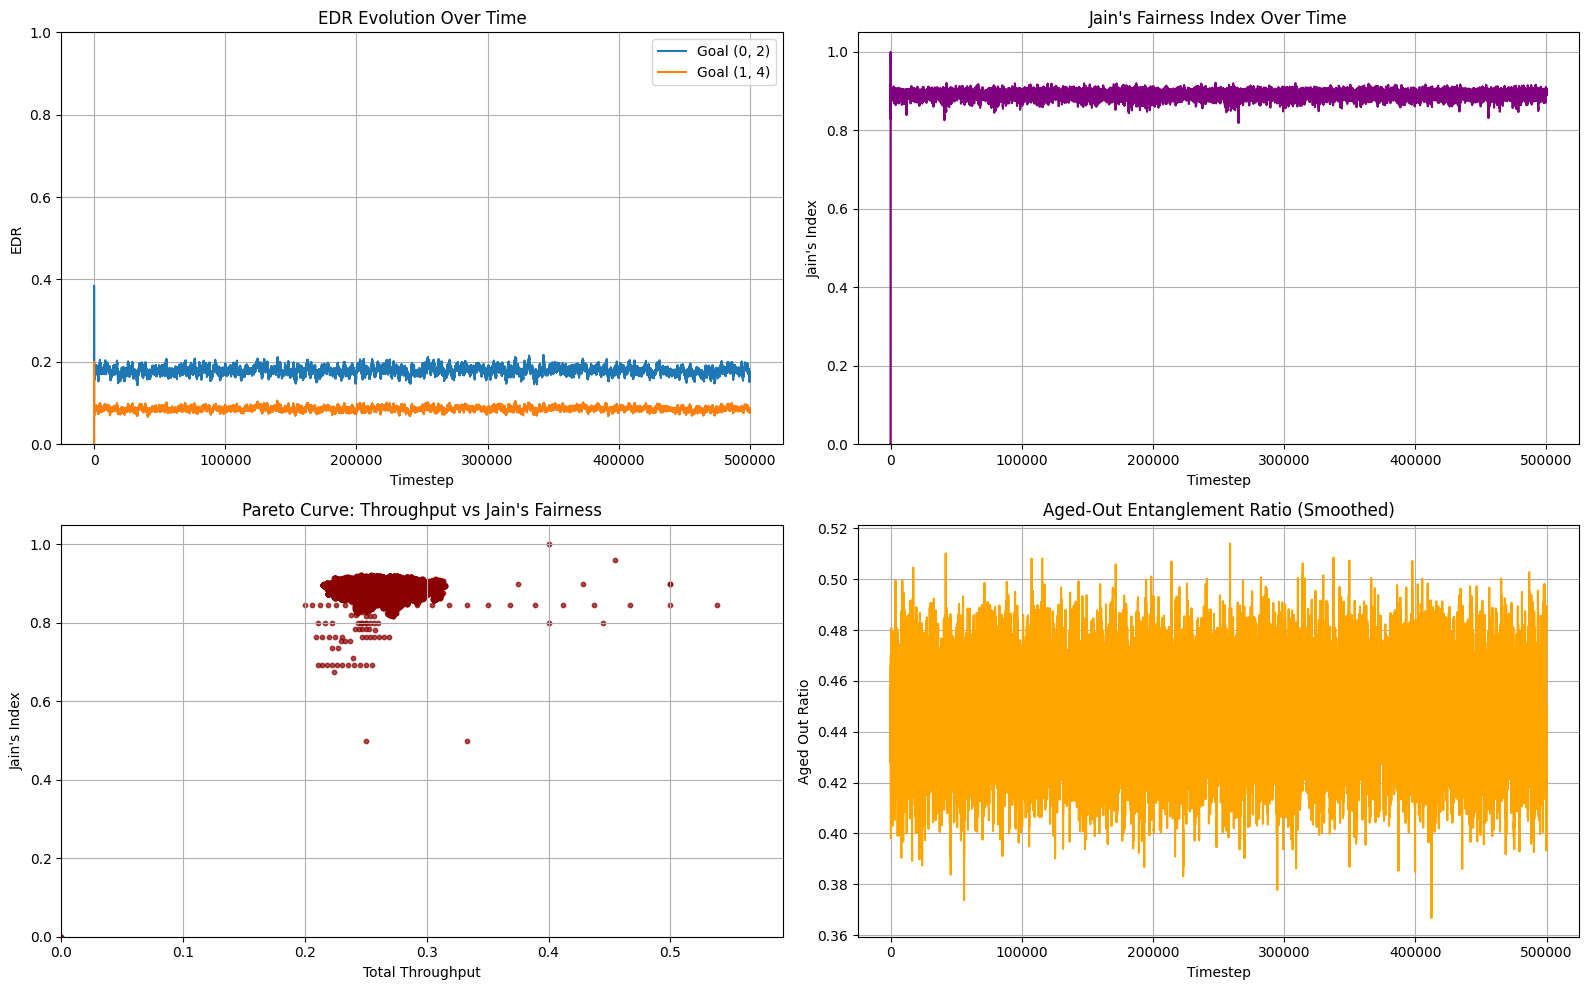

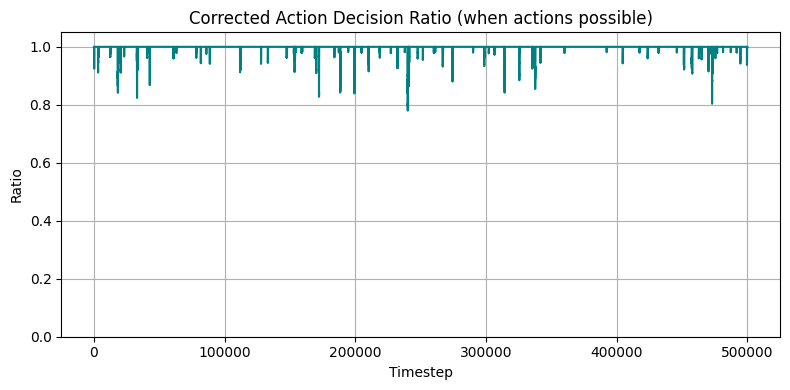

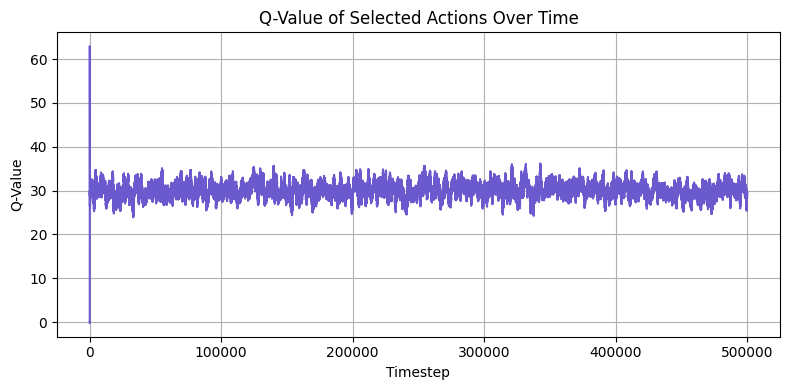

<Figure size 640x480 with 0 Axes>

({(0, 2): 89536, (1, 4): 43165},
 500000,
 {(0, 2): [0.0,
   0.0,
   0.3333333333333333,
   0.25,
   0.2,
   0.3333333333333333,
   0.2857142857142857,
   0.25,
   0.3333333333333333,
   0.3,
   0.2727272727272727,
   0.3333333333333333,
   0.38461538461538464,
   0.35714285714285715,
   0.3333333333333333,
   0.3125,
   0.29411764705882354,
   0.2777777777777778,
   0.2631578947368421,
   0.25,
   0.23809523809523808,
   0.22727272727272727,
   0.21739130434782608,
   0.20833333333333334,
   0.2,
   0.19230769230769232,
   0.18518518518518517,
   0.17857142857142858,
   0.1724137931034483,
   0.16666666666666666,
   0.16129032258064516,
   0.15625,
   0.15151515151515152,
   0.14705882352941177,
   0.14285714285714285,
   0.16666666666666666,
   0.16216216216216217,
   0.15789473684210525,
   0.1794871794871795,
   0.175,
   0.17073170731707318,
   0.16666666666666666,
   0.16279069767441862,
   0.18181818181818182,
   0.17777777777777778,
   0.1956521739130435,
   0.2127659574468085,

In [45]:
edges = [(0, 1), (1,2), (2,3), (3,4)]
goalEdges = [(0, 2), (1, 4)]
pSwap = 0.6
pGen = 0.6
maxAge = 2
totalSteps = 2000000
nLookahead = 3
epsilon = 0.05
gamma = 0.99
alpha = 0.1
edr_window_size=1000
temperature = 5
temperature_decay = 0.995
_, Q, _ = run_n_step_sarsa_linear(
    initialEdges=edges,
    goalEdges=goalEdges,
    totalSteps=totalSteps,
    nLookahead=nLookahead,
    epsilon=epsilon,
    gamma=gamma,
    alpha=alpha,
    pGen=pGen,
    pSwap=pSwap,
    maxAge=maxAge,
    edr_window_size=edr_window_size,
    plot=False,
    softmax=True, 
    temperature=temperature, 
    temperature_decay=temperature_decay
)

print(f'temperature {temperature}, temp decay {temperature_decay}, nlookahead{nLookahead}, steps {totalSteps}')
simulate_policy(Q_table=Q, edges=edges, goal_edges=goalEdges,
                p_swap=pSwap, p_gen=pGen, max_age=maxAge,
                num_steps=500000, edr_window_size=edr_window_size, plot=True)